# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn

import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors
import deepchem as dc

import torch
import torch.nn.functional as F
import botorch
import gpytorch

from src import molecules
from src.encoder import SelfiesEncoder
from src.vae import MolecularVAE
from src.train import VAELoss, train_vae
from src.transforms import Standardizer, UnitCubeScaler

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

# Preprocessing

Download raw dataset:

In [7]:
dataset_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

raw_df = pd.read_csv(dataset_url)
raw_df.to_csv(os.path.join("data", "qm9.csv"), index=False)

Add selfies encoding to raw data:

In [18]:
target_columns = ["alpha", "mu", "homo", "lumo", "gap", "r2", "zpve", "u0", "cv", "g298"]

In [19]:
df = pd.read_csv(os.path.join("data", "qm9.csv"))

# Add selfies strings
df["selfies"] = [sf.encoder(x, strict=False) for x in df.smiles]
df = df[["smiles", "selfies"] + target_columns]

# Standard scale target data
df[target_columns] = (df[target_columns] - df[target_columns].mean()) / df[target_columns].std()
df.to_csv(os.path.join("data", "qm9_processed.csv"), index=False)

## Molecular Features

In [313]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

In [418]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

sample_size = 1000
df_sample = df.sample(n=sample_size, random_state=12345)
df_sample.head()

,smiles,selfies,alpha,mu,homo,lumo,gap,r2,zpve,u0,cv,g298
13307,N#CCC1COC=N1,[N][#C][C][C][C][O][C][=N][Ring1][Branch1],-1.592773,1.451955,-1.279777,-0.181604,0.416669,-0.593075,-1.192598,0.818693,-1.652363,0.818707
103971,CN1C2CC(C)(CO)C12,[C][N][C][C][C][Branch1][C][C][Branch1][Ring1]...,0.813248,-1.008654,0.392053,0.966767,0.770212,-0.054942,1.339507,0.181054,1.248335,0.181041
46678,O=C1OCC2C3CC12O3,[O][=C][O][C][C][C][C][C][Ring1][#Branch1][Rin...,-1.241030,1.445812,-0.900226,-0.482012,-0.054723,-0.992539,-1.047439,-1.151843,-1.419499,-1.151761
64787,C1CC1(CC#CC#N)O,[C][C][C][Ring1][Ring1][Branch1][=Branch1][C][...,0.968357,1.055521,-1.591551,-1.189358,-0.433520,1.671889,-0.772990,0.270177,0.324021,0.270145
90963,CC1OC2C3OC2(C)C13,[C][C][O][C][C][O][C][Ring1][Ring2][Branch1][C...,-0.084430,-0.751400,0.423682,1.409923,1.195306,-0.636609,0.299953,-0.285287,-0.084598,-0.285248


In [503]:
rdkit_features = molecules.rdkit_features(df_sample.smiles)
targets = df_sample[target_columns]

In [420]:
x = StandardScaler().fit_transform(rdkit_features)
x_train = x[:sample_size/2]
x_test = x[sample_size/2:sample_size]

y_train = targets[:sample_size/2]
y_test = targets[sample_size/2:sample_size]

In [421]:
rf = RandomForestRegressor(random_state=12345)
multi_rf = MultiOutputRegressor(rf)
multi_rf.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=12345))

In [459]:
mean_importances = np.mean([x.feature_importances_ for x in multi_rf.estimators_], axis=0)
mean_importances.shape

(124,)

In [423]:
n_features = [1, 2, 5, 10, 20, 40, 80, 124]
r2_vals = []
for nf in n_features:
    print(f"Evaluating model for n_features = {nf}")
    selected_support = mean_importances.argsort()[-nf:]
    x_train_selected = x_train[:, selected_support]
    x_test_selected = x_test[:, selected_support]

    # Use a new RF for each trial without a fixed seed
    estimator = MultiOutputRegressor(estimator=rf)
    estimator.fit(x_train_selected, y_train)
    y_hat = estimator.predict(x_test_selected)
    r2_vals.append(r2_score(y_test, y_hat))

Evaluating model for n_features = 1
Evaluating model for n_features = 2
Evaluating model for n_features = 5
Evaluating model for n_features = 10
Evaluating model for n_features = 20
Evaluating model for n_features = 40
Evaluating model for n_features = 80
Evaluating model for n_features = 124


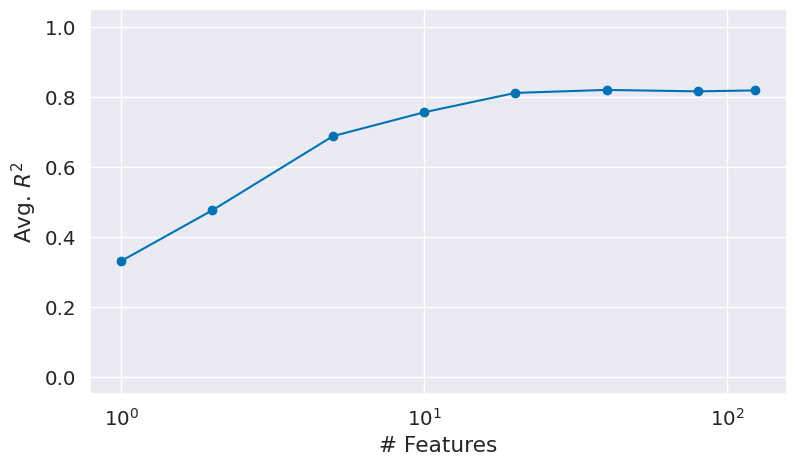

In [468]:
_, ax = plt.subplots(1, 1, figsize=(9, 5))

plt.plot(n_features, r2_vals, marker="o")

ax.set_xlabel("# Features")
ax.set_ylabel("Avg. $R^2$")
ax.set_ylim(-0.05, 1.05)
ax.set_xscale("log")

# plt.savefig("images/rdkit_feature_selection.png")
plt.show()

In [485]:
selected_indices = mean_importances.argsort()[-20:]
[featurizer.descriptors[idx] for idx in selected_indices]

['MaxPartialCharge',
 'MaxAbsPartialCharge',
 'VSA_EState5',
 'Kappa3',
 'BertzCT',
 'BCUT2D_MRHI',
 'PEOE_VSA4',
 'VSA_EState4',
 'Chi0',
 'TPSA',
 'VSA_EState2',
 'NumRotatableBonds',
 'LabuteASA',
 'Kappa1',
 'Chi0n',
 'FractionCSP3',
 'Chi0v',
 'HallKierAlpha',
 'MolMR',
 'HeavyAtomMolWt']

## Splits

In [530]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

selfies = df.selfies
selfies_encoder = SelfiesEncoder.build(selfies)

In [531]:
inputs = []
for s in tqdm(selfies):
    inputs.append(selfies_encoder.encode_one_hot(s))
inputs = torch.tensor(inputs)

inputs.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████| 133885/133885 [00:04<00:00, 28456.16it/s]


torch.Size([133885, 21, 29])

In [532]:
targets = torch.from_numpy(df[target_columns].to_numpy())

targets.shape

torch.Size([133885, 10])

In [533]:
descriptors = [
    'BCUT2D_MRHI',
    'BertzCT',
    'Chi0',
    'Chi0n',
    'Chi0v',
    'FractionCSP3',
    'HallKierAlpha',
    'HeavyAtomMolWt',
    'Kappa1',
    'Kappa3',
    'LabuteASA',
    'MaxAbsPartialCharge',
    'MaxPartialCharge',
    'MolMR',
    'NumRotatableBonds',
    'PEOE_VSA4',
    'TPSA',
    'VSA_EState2',
    'VSA_EState4',
    'VSA_EState5'
]

mols = [Chem.MolFromSmiles(s) for s in df.smiles]

rdkit_features = molecules.rdkit_features(mols, descriptors=descriptors)
rdkit_features = StandardScaler().fit_transform(rdkit_features)
rdkit_features = torch.from_numpy(rdkit_features)

Split the data and save:

In [534]:
gen = torch.manual_seed(42)

n = len(inputs)
train_size = 100000
val_size = 2000
test_size = n - train_size - val_size

random_indices = torch.randperm(n, generator=gen)
train_indices = random_indices[:train_size]
test_indices = random_indices[train_size:train_size+test_size]
val_indices = random_indices[train_size+test_size:]

inputs_train = inputs[train_indices]
inputs_test = inputs[test_indices]
inputs_val = inputs[val_indices]

targets_train = targets[train_indices]
targets_test = targets[test_indices]
targets_val = targets[val_indices]

features_train = rdkit_features[train_indices]
features_test = rdkit_features[test_indices]
features_val = rdkit_features[val_indices]

torch.save(inputs_train, os.path.join("data", "qm9_inputs_train.pt"))
torch.save(inputs_test, os.path.join("data", "qm9_inputs_test.pt"))
torch.save(inputs_val, os.path.join("data", "qm9_inputs_val.pt"))

torch.save(targets_train, os.path.join("data", "qm9_targets_train.pt"))
torch.save(targets_test, os.path.join("data", "qm9_targets_test.pt"))
torch.save(targets_val, os.path.join("data", "qm9_targets_val.pt"))

torch.save(features_train, os.path.join("data", "qm9_features_train.pt"))
torch.save(features_test, os.path.join("data", "qm9_features_test.pt"))
torch.save(features_val, os.path.join("data", "qm9_features_val.pt"))

# VAE

## Training

In [5]:
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train = torch.load(os.path.join("data", "qm9_inputs_train.pt"))
x_test = torch.load(os.path.join("data", "qm9_inputs_test.pt"))

y_train = torch.load(os.path.join("data", "qm9_targets_train.pt"))
y_test = torch.load(os.path.join("data", "qm9_targets_test.pt"))

x_train = x_train.to(device).float()
x_test = x_test.to(device).float()
y_train = y_train.to(device).float()
y_test = y_test.to(device).float()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

In [6]:
batch_size = 250

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
latent_size = 50
model = MolecularVAE(
    latent_size=latent_size, 
    target_size=y_train.shape[1]
)
model.to(device)

print(f"# Parameters = {model.n_parameters()}")
model

# Parameters = 4036195


MolecularVAE(
  (encoder_conv): Sequential(
    (0): Conv1d(29, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(9, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(9, 10, kernel_size=(10,), stride=(1,), padding=(2,))
    (5): ReLU()
  )
  (encoder_linear): Sequential(
    (0): Linear(in_features=80, out_features=400, bias=True)
    (1): SELU()
  )
  (encoder_mean): Linear(in_features=400, out_features=50, bias=True)
  (encoder_logvar): Linear(in_features=400, out_features=50, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): SELU()
  )
  (decoder_gru): GRU(50, 500, num_layers=3, batch_first=True)
  (decoder_output): Linear(in_features=500, out_features=29, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=50, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_feat

In [8]:
criterion = VAELoss(beta=1e-3)

learning_rate = 2e-3
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=1e-5 ,
)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[15, 30, 50, 70, 90], 
    gamma=0.5
)

In [9]:
n_epochs = 120
tracker = train_vae(
    model,
    criterion,
    optimizer,
    lr_scheduler,
    train_loader,                                                                                                                                                                                                                  
    test_loader,
    n_epochs=n_epochs,
    print_every=1
)

0 | train_elbo = 27.859 | test_elbo = 24.162 | train_mse = 9.516 | test_mse = 7.683 | train_accuracy = 0.000 | test_accuracy = 0.000
1 | train_elbo = 23.404 | test_elbo = 24.177 | train_mse = 5.776 | test_mse = 5.391 | train_accuracy = 0.000 | test_accuracy = 0.000
2 | train_elbo = 21.465 | test_elbo = 18.319 | train_mse = 4.710 | test_mse = 3.967 | train_accuracy = 0.000 | test_accuracy = 0.000
3 | train_elbo = 18.255 | test_elbo = 16.749 | train_mse = 3.894 | test_mse = 3.649 | train_accuracy = 0.000 | test_accuracy = 0.001
4 | train_elbo = 16.601 | test_elbo = 16.033 | train_mse = 3.616 | test_mse = 3.547 | train_accuracy = 0.001 | test_accuracy = 0.000
5 | train_elbo = 15.394 | test_elbo = 14.865 | train_mse = 3.516 | test_mse = 3.517 | train_accuracy = 0.001 | test_accuracy = 0.002
6 | train_elbo = 14.823 | test_elbo = 14.510 | train_mse = 3.489 | test_mse = 3.461 | train_accuracy = 0.001 | test_accuracy = 0.002
7 | train_elbo = 14.237 | test_elbo = 13.795 | train_mse = 3.455 | te

KeyboardInterrupt: 

NameError: name 'tracker' is not defined

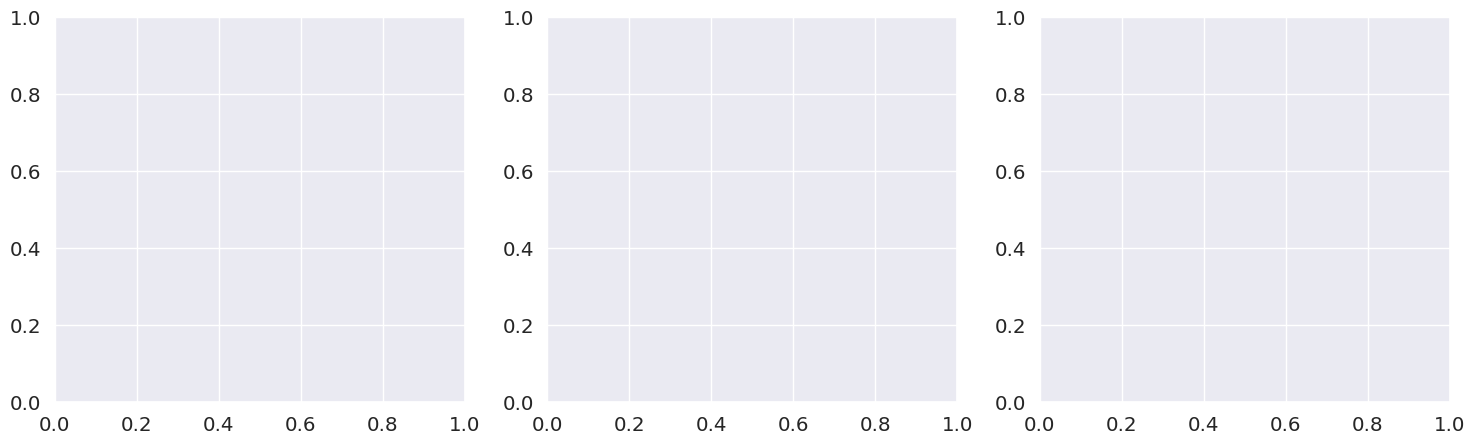

In [540]:
_, ax = plt.subplots(1, 3, figsize=(18, 5))

train_elbo = tracker.get("train_elbo")
test_elbo = tracker.get("test_elbo")

train_mse = tracker.get("train_mse")
test_mse = tracker.get("test_mse")

train_accuracy = tracker.get("train_accuracy")
test_accuracy = tracker.get("test_accuracy")

ax[0].plot(train_elbo[:,0], train_elbo[:,1], label='Train')
ax[0].plot(test_elbo[:,0], test_elbo[:,1], label='Test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('ELBO')
ax[0].legend()

ax[1].plot(train_mse[:,0], train_mse[:,1], label='Train')
ax[1].plot(test_mse[:,0], test_mse[:,1], label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].legend()

ax[2].plot(train_accuracy[:,0], train_accuracy[:,1], label='Train')
ax[2].plot(test_accuracy[:,0], test_accuracy[:,1], label='Test')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].legend()

# plt.savefig(os.path.join("images", f"vae_latent_{latent_size}_constant.png"))
plt.show()

In [39]:
# torch.save(model.state_dict(), os.path.join("models", f"vae_latent_{latent_size}_constant.pt"))

## Characterization

In [12]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

inputs_test = torch.load(os.path.join("data", "qm9_inputs_test.pt")).float()
targets_test = torch.load(os.path.join("data", "qm9_targets_test.pt"))

selfies = list(df.selfies)
selfies_encoder = SelfiesEncoder.build(selfies)

In [41]:
vae_tags = [(25, "constant"), (50, "constant"), (100, "constant")]

vaes = {}
for latent_size, beta in vae_tags:
    params = torch.load(os.path.join("models", f"vae_latent_{latent_size}_constant.pt"))
    vae = MolecularVAE(latent_size=latent_size)
    vae.load_state_dict(params)
    vae.eval()

    name = f"{latent_size}_{beta}"
    vaes[name] = vae   

### Latent Distribution

In [13]:
#vae = vaes["100_constant"]
vae = model
vae = vae.cpu().float()

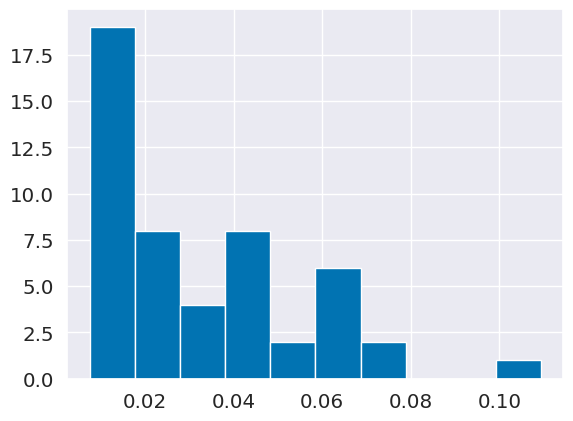

In [14]:
z_logvars = vae.encode(inputs_test)[1].detach().cpu()

z_stds = z_logvars.mean(dim=0).exp().sqrt()

plt.hist(z_stds, bins=10)
plt.show()

### Interpolation

In [15]:
start_selfie = sf.encoder("C")
end_selfie = sf.encoder("C(CC=O)C(CC=O)")

start_x = torch.tensor(selfies_encoder.encode_one_hot(start_selfie), dtype=torch.float32)
end_x = torch.tensor(selfies_encoder.encode_one_hot(end_selfie), dtype=torch.float32)

interp_x = vae.interpolate(start_x, end_x, 5)
interp_x = interp_x

interp_selfies = [selfies_encoder.decode_tensor(x) for x in interp_x]
interp_mols = [Chem.MolFromSmiles(sf.decoder(s)) for s in interp_selfies]

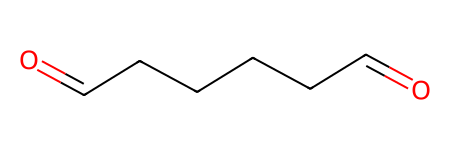

In [16]:
Chem.MolFromSmiles(sf.decoder(end_selfie))

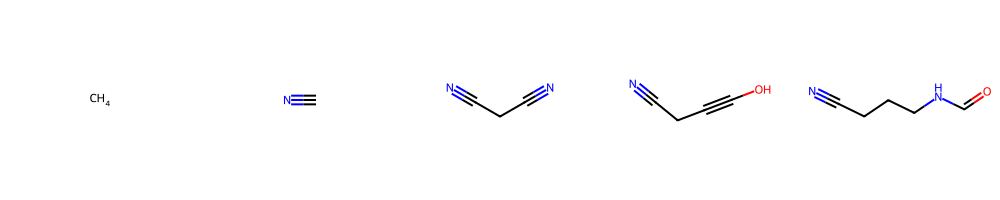

In [17]:
Chem.Draw.MolsToGridImage(interp_mols, molsPerRow=5)

### Regression

In [18]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

import umap

torch.manual_seed(145);

/home/sfriedowitz/miniconda3/envs/ssl/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sfriedowitz/miniconda3/envs/ssl/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sfriedowitz/miniconda3/envs/ssl/lib/python3.11/site-packag

In [19]:
inputs_val = torch.load(os.path.join("data", "qm9_inputs_val.pt")).float()
targets_val = torch.load(os.path.join("data", "qm9_targets_val.pt")).float()
features_val = torch.load(os.path.join("data", "qm9_features_val.pt")).float()
inputs_val.shape

torch.Size([2000, 21, 29])

In [20]:
selfies_sample = [selfies_encoder.decode_tensor(xi) for xi in inputs_val]
mols_sample = [Chem.MolFromSmiles(sf.decoder(s)) for s in selfies_sample]
target_sample = [molecules.penalized_logp(m) for m in mols_sample]

In [21]:
z = vae.encode(inputs_val)[0].detach().double()

y = torch.tensor(target_sample).view(-1, 1).double()

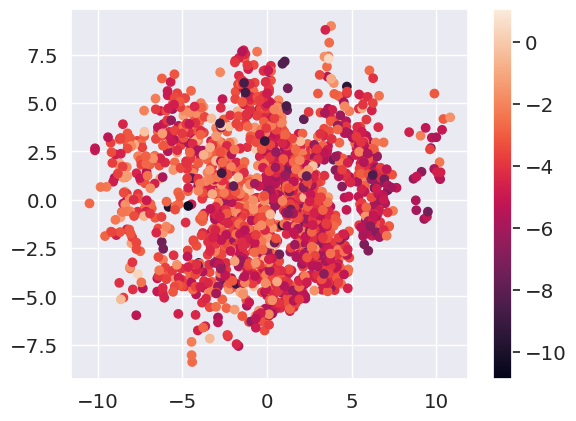

In [22]:
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=y)
plt.colorbar()

plt.show()

In [23]:
indices = torch.randperm(z.shape[0])

n_train = 500

ind_train = indices[:n_train]
ind_test = indices[n_train:]

z_train = z[ind_train]
z_test = z[ind_test]

y_train = y[ind_train]
y_test = y[ind_test]

input_scaler = UnitCubeScaler.build(z_train)
z_train_scaled = input_scaler.transform(z_train)
z_test_scaled = input_scaler.transform(z_test)

output_scaler = Standardizer.build(y_train)
y_train_scaled = output_scaler.transform(y_train)
y_test_scaled = output_scaler.transform(y_test)

In [24]:
gp = SingleTaskGP(z_train_scaled, y_train)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

mll = fit_gpytorch_mll(mll)

/home/sfriedowitz/miniconda3/envs/ssl/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-4.0041], dtype=torch.float64), std = tensor([1.5525], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [25]:
mvn = gp(z_test_scaled)

y_pred_mean = mvn.mean.detach()

In [26]:
r2_score(y_test, y_pred_mean)

0.32324375695686247

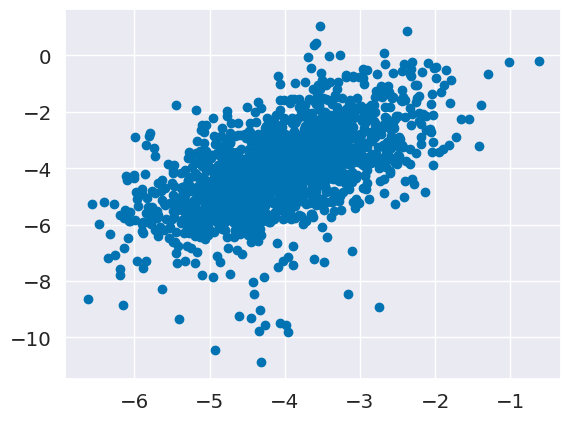

In [27]:
plt.scatter(y_pred_mean, y_test.flatten())

plt.show()